In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pandas as pd

In [2]:
def calibrate_camera(image_files, nx, ny, draw=False):
    
    objpoints = []    # 3D Points in real world space
    imgpoints = []    # 2D Points in the image plane

    # Prepare a grid of the coordiates of the chessboard corners, assuming 3D coords.
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)

    for file in image_files:
        # Read the image file
        img = mpimg.imread(file)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, draw corners
        if ret == True:
            if draw:
                # Draw and display the corners
                plt.figure(figsize=(10, 10))
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)

            # Append corners and grid to array
            imgpoints.append(corners)
            objpoints.append(objp)

    # Calibrate the camera using the corner points found from the chessboard images
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    if draw:
        # Test on a distorted image to see if we can undistort it
        img = mpimg.imread('camera_cal/calibration2.jpg')
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        # Compare the original with the undistorted image, side-by-side
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()

    return mtx, dist

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def calc_slopes(lines):
    slopes = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            if abs(x2 - x1) > 0:
                slopes = np.append(slopes, [float(y2-y1)/(x2-x1)], axis=0)
            
    return slopes

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return {'img': line_img, 'lines': lines}

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Helper Functions for Color and Gradient Tresholding
def abs_sobel_thresh(input_ch, orient='x', sobel_kernel=3, thresh=(0, 255)):
    '''Takes a 2D single channel image, including grayscale, calculates the Sobel derivative in either the x
       or y direction, and returns a gradient mask that takes on a value of 1 at positions where the Sobel 
       derivative is between some threshold values.
       
       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       orient - You can specify whether to take the Sobel derivative in the x or y direction
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the Sobel derivative if the
                mask at that position is to be 1.
        
       Outputs:
       grad_binary - A mask that with value 1 in positions where the Sobel derivative of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the derivative or gradient
    abs_Sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_abs_sobel = np.uint8(255*abs_Sobel/np.max(abs_Sobel))
    # Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_abs_sobel)
    grad_binary[(scaled_abs_sobel >= thresh[0]) & (scaled_abs_sobel <= thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return grad_binary

def mag_thresh(input_ch, sobel_kernel=3, thresh=(0, 255)):
    '''Takes a 2D single channel image, including grayscale, calculates the gradient magnitude of the
       Sobel derivative in both the x and y direction, and returns a gradient mask that takes on a value of 1 
       at positions where the gradient magnitude is between some threshold values.

       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the gradient magnitude
                    if the mask at that position is to be 1.

       Outputs:
       mag_binary - A mask that with value 1 in positions where the gradient magnitude of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the gradient in x and y separately
    gradient_x = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    gradient_y = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Calculate the magnitude 
    gradient_magn = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    grad_magn_scaled = np.uint8(255*gradient_magn/np.max(gradient_magn))
    # Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(grad_magn_scaled)
    mag_binary[(grad_magn_scaled > thresh[0]) & (grad_magn_scaled < thresh[1])] = 1

    # Return this mask 
    return mag_binary

def dir_thresh(input_ch, sobel_kernel=3, thresh=(0, np.pi/2)):
    '''Takes a 2D single channel image, including grayscale, calculates the gradient direction of the
       Sobel derivative and returns a gradient mask that takes on a value of 1 at positions where the 
       gradient direction is between some threshold values.

       Inputs:
       input_ch - 2D array that represents a channel of a color image, or a grayscale image
       sobel_kernel - The size of one side of the Sobel operator, which is a square. Must be odd.
       thresh - A tuple that represents the min and max of the threshold values of the gradient direction
                    if the mask at that position is to be 1.

       Outputs:
       dir_binary - A mask that with value 1 in positions where the gradient direction of the image is between the
                     min and max threshold values specified in the input
    '''
    
    # Take the gradient in x and y separately
    gradient_x = cv2.Sobel(input_ch, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    gradient_y = cv2.Sobel(input_ch, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_grad_x = np.absolute(gradient_x)
    abs_grad_y = np.absolute(gradient_y)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_direction = np.arctan2(abs_grad_y, abs_grad_x)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(grad_direction)
    dir_binary[(grad_direction >= thresh[0]) & (grad_direction <= thresh[1])] = 1
    
    # Return this mask 
    return dir_binary

def make_thresh_binaries(binary_warped, input_dict):
    '''Takes an image and a dictionary of desired image channel and thresholding operations, and returns
       a dictionary of the various binary masks created based on those inputs.
       
       Inputs:
       binary_warped - A color image that is the basis for the mask
       input_dict - A dictionary that has this structure:
                     channel - A string that indicates what image channel to perform the threshold operations on.
                               Some examples are 'gray' for grayscale, 'R' for the Red channel, 'HSV_S' for the 
                               S channel of an HSV image.
                     grad_ops - A list of dictionaries that define the threshold operations that are to be performed
                               on the channel. The dictionary has this structure:
                                   op - A string that indicates the treshold operations. Some examples are 
                                   'mag_binary' for the gradient magnitude binary, and 'abs_sobel_binaryx' 
                                   for a Sobel derivative in the x direction.
                                   ksize - An integer that represents the Sobel kernel size, if applicable
                                   threshold - A tuple of two integers that represent the min and max threshold 
                                   values of the threshold operation
        
        Outputs:
        binary_dict - A dictionary of the binary mask that results in applying the threshold operations specified
                      in the input on the channels specified in the input.   
    '''
    
    binary_warped = np.copy(binary_warped)
    binary_dict = {}

    # Convert to HSV color space
    hsv = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2HSV)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2HLS)
    
    # Go through the desired channels to include in the mask
    for inputs in input_dict:
        ch = inputs['channel']
        if ch == 'gray':
            channel = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
        if ch == 'R':
            channel = binary_warped[:, :, 0]
        if ch == 'G':
            channel = binary_warped[:, :, 1]
        if ch == 'B':
            channel = binary_warped[:, :, 2]
        if ch == 'HSV_H':
            channel = hsv[:, :, 0]
        if ch == 'HSV_S':
            channel = hsv[:, :, 1]
        if ch == 'HSV_V':
            channel = hsv[:, :, 2]
        if ch == 'HLS_H':
            channel = hls[:, :, 0]
        if ch == 'HLS_L':
            channel = hls[:, :, 1]
        if ch == 'HLS_S':
            channel = hls[:, :, 2]
        
        # Create masks based on the operations in the input
        for ops in inputs['grad_ops']:
            if ops['op'][:-1] == 'abs_sobel_binary':
                binary_dict[ops['op'] + '_' + ch] = abs_sobel_thresh(
                    channel, ops['op'][-1], ops['ksize'], ops['thresholds'])
            if ops['op'] == 'mag_binary':
                binary_dict[ops['op'] + '_' + ch] = mag_thresh(
                    channel, ops['ksize'], ops['thresholds'])
            if ops['op'] == 'dir_binary':
                binary_dict[ops['op'] + '_' + ch] = dir_thresh(
                    channel, ops['ksize'], ops['thresholds'])
            if ops['op'] == 'ch_thresh_binary':
                ch_binary = np.zeros_like(channel)
                ch_binary[(channel >= ops['thresholds'][0]) & (channel <= ops['thresholds'][1])] = 1
                binary_dict[ops['op'] + '_' + ch] = ch_binary
                
    return binary_dict

def make_binary_mask(binary_dict):
    '''Create a mask based on the treshold binaries from the input.
    
       Inputs:
       binary_dict - A dictionary of the binary threshold maps, in which the key is a string of the name of
                     the threshold operation and the channel the operation was performed on.   
        
       Outputs:
       mask - A binary mask that results from some combination of the binary threshold maps.
    '''
    
    # Create the treshold mask of the same size as any of the binary masks
    mask_r = np.zeros_like(binary_dict['abs_sobel_binaryx_R'])
    mask_g = np.zeros_like(mask_r)    
    mask_b = np.zeros_like(mask_g)

    # Create the mask layers by using some logical combination of the threshold binaries
#     mask_r[((binary_dict['abs_sobel_binaryx_gray'] == 1) & (binary_dict['abs_sobel_binaryy_gray'] == 1))] = 1 
#     mask_g[((binary_dict['abs_sobel_binaryx_R'] == 1) & (binary_dict['abs_sobel_binaryy_R'] == 1))] = 1  
    mask_r[((binary_dict['abs_sobel_binaryx_gray'] == 1))] = 1 
    mask_g[((binary_dict['abs_sobel_binaryx_R'] == 1))] = 1  
    mask_b[((binary_dict['ch_thresh_binary_HLS_S'] == 1) & (binary_dict['ch_thresh_binary_HLS_H'] == 1))] = 1
    
    color_binary = np.dstack((mask_r, mask_g, mask_b))*255
    combined_binary = np.zeros_like(mask_g)
    combined_binary[((mask_r == 1) & (mask_g == 1)) | (mask_b == 1)] = 1
 
    return color_binary, combined_binary

def transform_perspective(image, src, dst):
    '''
        Takes an image and does a perspective transform of it based on the inputs. Returns the
        transformed image and the transform and inverse transfrom matrices.
    '''
    
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    result = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return result, M, Minv

def draw_lane_lines(edges, image):    

    imshape = edges.shape

    # Assume a max value of y for the top edge of the polygon
    y_max = imshape[0]/2*(450/360)
    # Apply an image mask on the region of interest
    # Setup the vertices of the polygon that defines the region of interest
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-80, y_max),
                (imshape[1]/2+80, y_max), (imshape[1],imshape[0])]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges*255, vertices)
    masked_edge_img = np.dstack((masked_edges, masked_edges, masked_edges)) 
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(masked_edge_img, cmap='gray')
#     plt.show()
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    ### These are the original parameter values
#     rho = 2 # distance resolution in pixels of the Hough grid
#     theta = np.pi*2/180 # angular resolution in radians of the Hough grid
#     threshold = 90 # minimum number of votes (intersections in Hough grid cell)
#     min_line_length = 40 # minimum number of pixels making up a line
#     max_line_gap = 20    # maximum gap in pixels between connectable line segments
#     line_image = np.copy(image)*0 # creating a blank to draw lines on

    rho = 4 # distance resolution in pixels of the Hough grid
    theta = np.pi*2/180 # angular resolution in radians of the Hough grid
    threshold = 80 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 30 # minimum number of pixels making up a line
    max_line_gap = 30    # maximum gap in pixels between connectable line segments

    # Run Hough on edge detected image
    # Output a dictionary containing the image and an array of the edge line segment endpoints
    hough_dict = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    # Get the line images
    line_img = hough_dict['img']
    # Get the line segments of the edges 
    lines = hough_dict['lines']
    canny_lines = weighted_img(line_img, masked_edge_img)
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(canny_lines, cmap='gray')
#     plt.show()
    
    ## Calculate the left-lane extrapolation line
    # Sort the line segments by the y1 coordinates in ascending order
    lines = lines[lines[:, 0, 1].argsort()]
    # Calculate the slopes of the sorted line segments
    slopes = calc_slopes(lines)
    # Get the left-lane line segments, which have negative slopes
    l_inx = np.where(slopes < -0.4)
    l_slopes = slopes[l_inx]
    if(len(l_slopes) > 1):
        lower_bnd = np.percentile(l_slopes, 25)
        upper_bnd = np.percentile(l_slopes, 75)
        l_inx = np.where((slopes >= lower_bnd) & (slopes <= upper_bnd))
        l_slopes = slopes[l_inx]

    l_slope = 0
    if(len(l_slopes) > 0):
        # Get the median slope of the left-lane segments
        l_slope = np.median(l_slopes)
    
    # Calculate the x-coord of the point where an extrapolated line that runs through the left lane
    # intersects the bottom edge of the image - called x-intercept here, even though it's not technically that
    x_l_intcp = 0
    x_l_intercepts = np.array([])
    for line in lines[l_inx]:
        x_l_intcp_1 = float(imshape[0] - line[0][1])/l_slope + line[0][0]
        x_l_intcp_2 = float(imshape[0] - line[0][3])/l_slope + line[0][2]
        x_l_intercepts = np.append(x_l_intercepts, [x_l_intcp_1, x_l_intcp_2])  
    if(len(x_l_intercepts) > 0):
        x_l_intcp = np.average(x_l_intercepts)
    
    # Calculate the y-intercept of an extrapolated line that runs through bottom-most point of the left lane
    y_l_intcp = imshape[0] - l_slope*x_l_intcp

    ## Repeat for the right-lane
    # Now sort the line segments by the y2 coordinate
    lines = lines[lines[:, 0, 3].argsort()]
    # Calculate the slopes on this newly sorted array
    slopes = calc_slopes(lines)

    # Get the right-lane line segments, which have positive slopes
    r_inx = np.where(slopes > 0.4)
    r_slopes = slopes[r_inx]
    if(len(r_slopes) > 1):
        lower_bnd = np.percentile(r_slopes, 25)
        upper_bnd = np.percentile(r_slopes, 75)
        r_inx = np.where((slopes >= lower_bnd) & (slopes <= upper_bnd))
        r_slopes = slopes[r_inx]
    
    r_slope = 0
    if(len(r_slopes) > 0):
        # Get the median slope of the left-lane segments
        r_slope = np.median(r_slopes)

    # Calculate the x-coord of the point where an extrapolated line that runs through the right lane
    # intersects the bottom edge of the image - called x-intercept here, even though it's not technically that
    x_r_intcp = 0
    x_r_intercepts = np.array([])
    for line in lines[r_inx]:
        x_r_intcp_1 = float(imshape[0] - line[0][1])/r_slope + line[0][0]
        x_r_intcp_2 = float(imshape[0] - line[0][3])/r_slope + line[0][2]
        x_r_intercepts = np.append(x_r_intercepts, [x_r_intcp_1, x_r_intcp_2]) 
    if(len(x_r_intercepts) > 0):
        x_r_intcp = np.average(x_r_intercepts)

    # Calculate the y-intercept of an extrapolated line that runs through the right lane
    y_r_intcp = imshape[0] - r_slope*x_r_intcp
    
    # Calculate the x and y coordinate of the point where left and right lines intersect
    x_cross = 0
    y_cross = 0
    if(abs(r_slope - l_slope) > 0):
        x_cross = float(y_l_intcp - y_r_intcp)/(r_slope - l_slope)
        y_cross = float(y_l_intcp*r_slope - y_r_intcp*l_slope)/(r_slope - l_slope)
        
    # If y_cross is greater than or equal to the y value marking the top edge of the region of interest,
    # then the left and right lanes cross in the image output. Move the y value up some value and then
    # calculate the top endpoints of the left and right extrapolated lines
    if(y_cross >= y_max):
        y_t = y_cross*1.05
    else:
        y_t = y_max

    # Calculate the x coord of the top-most endpoint of the left line using y_t as the endpoint's y coord
    x_l_t = 0
    y_l_t = 0
    if(abs(l_slope) > 0):
        x_l_t = x_l_intcp - float(imshape[0] - y_t)/l_slope
        y_l_t = y_t
    # Calculate the x coord of the top-most endpoint of the RIGHT line using y_t as the endpoint's y coord
    x_r_t = 0
    y_r_t = 0
    if(abs(r_slope) > 0):
        x_r_t = x_r_intcp - float(imshape[0] - y_t)/r_slope
        y_r_t = y_t

    # Create an array of endpoints that make up the extrapolated left and right-lane lines
    ext_lines = np.array([[[int(x_l_intcp), imshape[0], int(x_l_t), int(y_t)],
                            [int(x_r_t), int(y_t), int(x_r_intcp), imshape[0]]]])
    
#     print(ext_lines)
    
    # Draw the extrapolated lines on a blank image
    extr_line_img = np.zeros((*imshape, 3), dtype=np.uint8)
    draw_lines(extr_line_img, ext_lines, thickness = 2)
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(extr_line_img, cmap='gray')
#     plt.show()
    
    # Draw the top horizontal line that connects the left and right lines
    cv2.line(extr_line_img, (ext_lines[0, 0, 2], ext_lines[0, 0, 3]), 
             (ext_lines[0, 1, 0], ext_lines[0, 1, 1]), [255, 0, 0], 2)
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(extr_line_img, cmap='gray')
#     plt.show()
    
    # Draw the lines on the original image
    final_img = weighted_img(extr_line_img, image)
    
#     plt.figure(figsize=(20, 9))
#     plt.imshow(final_img, cmap='gray')
#     plt.show()

    return final_img, masked_edges, ext_lines

def process_image(image, mtx, dist, prev_m, prev_minv):
    '''
        Creates a binary mask of the input image detecting lane edges and transforms it
        to a top-down(i.e. bird's eye) view.
    '''
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    input_dict = [{'channel': 'R', 'grad_ops': [{'op': 'abs_sobel_binaryx', 'ksize': 9, 'thresholds': (30, 200)},
                                                {'op': 'abs_sobel_binaryy', 'ksize': 9, 'thresholds': (30, 200)},
                                                {'op': 'mag_binary', 'ksize': 3, 'thresholds': (20, 150)},
                                                {'op': 'dir_binary', 'ksize': 3, 'thresholds': (1.0, 1.3)}]},

                  {'channel': 'gray', 'grad_ops': [{'op': 'abs_sobel_binaryx', 'ksize': 9, 'thresholds': (30, 200)},
                                                   {'op': 'abs_sobel_binaryy', 'ksize': 9, 'thresholds': (30, 200)},  
                                                   {'op': 'mag_binary', 'ksize': 3, 'thresholds': (20, 150)},
                                                   {'op': 'dir_binary', 'ksize': 3, 'thresholds': (0.7, 1.3)}]},

                  {'channel': 'HLS_S', 'grad_ops': [{'op': 'ch_thresh_binary', 'thresholds': (180, 255)}]},

                  {'channel': 'HLS_H', 'grad_ops': [{'op': 'ch_thresh_binary', 'thresholds': (10, 100)}]}]

    binary_dict = make_thresh_binaries(undist, input_dict)
    color_binary, combined_binary = make_binary_mask(binary_dict)
    final_img, masked_binary, ext_lines = draw_lane_lines(combined_binary, image)
    
#     print('CB ' + str(np.max(combined_binary)))
#     plt.figure(figsize=(20, 9))
#     plt.imshow(combined_binary, cmap='gray')
#     plt.show()

#     print('MB ' + str(np.max(masked_binary)))
#     plt.figure(figsize=(20, 9))
#     plt.imshow(masked_binary, cmap='gray')
#     plt.show()

    # Reshape the endpoints of the left and right lane lines into a source matrix for the perspective transform
    src = np.float32(ext_lines.reshape(4, 2))
    dst = np.float32([[300, 700],
                     [300, 0],
                     [1000, 0],
                     [1000, 700]])    
    # Transform the masked binary into a top-down view
    binary_warped, M, Minv = transform_perspective(masked_binary, src, dst)
    nonzeros = binary_warped.nonzero()
    # Set all nonzero values to 255 so the final binary warped image is black and white
    binary_warped[nonzeros[0], nonzeros[1]] = 255    
    # If the image processing did not detect any edges, then use the previous Minv for the transform
    if ((len(nonzeros[0]) == 0) and (len(nonzeros[1]) == 0)): 
        img_size = (binary_warped.shape[1], binary_warped.shape[0])
        result = cv2.warpPerspective(image, prev_m, img_size, flags=cv2.INTER_LINEAR)
        M = prev_m
        Minv = prev_minv
        
#     print('BW ' + str(np.max(binary_warped)))
#     plt.figure(figsize=(20, 9))
#     plt.imshow(binary_warped, cmap='gray')
#     plt.show()
#     print(binary_warped[nonzeros[0], nonzeros[1]])
    
    return binary_warped, undist, M, Minv

def calc_curve(y_eval, lefty, leftx, righty, rightx):
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                           left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                            right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad
    
def find_lane_lines(binary_warped):

    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    binary_warped_3d = np.dstack((binary_warped, binary_warped, binary_warped))
    out_img = np.copy(binary_warped_3d)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y coords of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
#         cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
#         cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the indices of the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Flatten the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    ########################## For Testing Purposes Only - Comment Out Later #################################
    # Extract left and right line pixel positions
#     leftx = nonzerox[left_lane_inds]
#     lefty = nonzeroy[left_lane_inds] 
#     rightx = nonzerox[right_lane_inds]
#     righty = nonzeroy[right_lane_inds]

#     # Fit a second order polynomial to each
#     left_fit = np.polyfit(lefty, leftx, 2)
#     right_fit = np.polyfit(righty, rightx, 2)  

#     # Generate x and y values for plotting
#     ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#     polys = np.zeros_like(out_img)
#     polys[np.int32(ploty), np.int32(left_fitx)] = [255, 255, 0]
#     polys[np.int32(ploty), np.int32(right_fitx)] = [255, 255, 0]
    
#     out_img = cv2.bitwise_or(out_img, polys)
    
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
#     return out_img

    ################################################################################################   
    
    return left_lane_inds, right_lane_inds


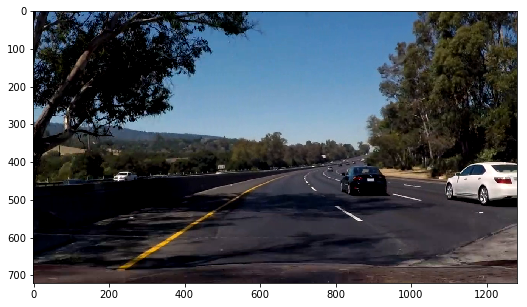

In [173]:
# images = np.array(frame.images)
# print(images.shape)
fig, ax = plt.subplots(figsize=(10,5))
img = images[0]
ax.imshow(img)
plt.show()

result = process_image(img, mtx, dist, frame.prev_m, frame.prev_minv)


In [29]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = []
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # An array of the last n sets of coefficients
        self.poly_coeffs = []
        #polynomial coefficients for the most recent fit  
        self.current_fit = np.array([False])
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # A record of all the best fit polynomial coefficients
        self.all_best_fits = []
        # A record of all the non-averaged fit polynomial coefficients
        self.all_coeffs = []
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # Current distance between lanes
        self.current_lane_dist = None
        # Previous distance bewteen lanes
        self.prev_lane_dist = None
        # A list of all the distances between the lanes
        self.all_dists = []
        # A list of all the lane pixels detected
        self.lane_inds = []
        # The number of high-confidence lane detections we have observed
        self.d = 0

# Define a class to keep track of frame counts and lost frames
class Frame():
    def __init__(self):
        # The number of frames in the video
        self.frame_count = 0
        # The number of frames where we failed to find a lane
        self.frames_lost = 0
        # The total number of frames lost in all
        self.total_frames_lost = 0
        # The number of times we had to search for the lanes from scratch
        self.searches = 0
        # Counter
        self.cnt = 0
        # A record of the frame in which we started a new search
        self.lost_frame = None
        # The previous frame's transform matrix
        self.prev_m = None
        # The previous frame's inverse transform matrix
        self.prev_minv = None
        
        self.images = []
        
def run_pipeline(image):
    '''Takes an image, undistorts it, creates a binary mask using thresholding on select image channels, 
       searches for lane pixels, fits a polynomial curve to the set of highly-probable lane pixels, and saves
       information about the lanes to an instance of the class Line.
    '''
    
    # Initialize key variables
    binary_warped, undist, M, Minv = process_image(image, mtx, dist, frame.prev_m, frame.prev_minv)
    frame.prev_m = M
    frame.prev_minv = Minv
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    left_line.prev_lane_dist = left_line.current_lane_dist
    
#     frames = np.arange(1041, 1051)
#     if frame.frame_count in frames:
#         frame.images.append(image)
    
    # Search for lanes using sliding windows if neither left or right lanes were detected from last frame
    if not(left_line.detected and right_line.detected):
        left_lane_inds, right_lane_inds = find_lane_lines(binary_warped)
        frame.searches += 1
    # If lanes were detected from previous frames, then proceed with best fit to detect lanes
    else:      
        # Use the average "best" fit poly coefficients to find the left and right lane pixels
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                           left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                           left_fit[1]*nonzeroy + left_fit[2] + margin))).nonzero()[0]
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                            right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                            right_fit[1]*nonzeroy + right_fit[2] + margin))).nonzero()[0]
                
    # Check if a lane could be detected using the existing fit
    if ((len(left_lane_inds) > 0) and (len(right_lane_inds) > 0)): 
        # Reset the number of frames in which the lanes were lost
        frame.frames_lost = 0
        left_line.detected = True
        right_line.detected = True
        
        # Extract left and right lane pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Update the current state of the left and right line pixel positions
        left_line.allx = leftx
        left_line.ally = lefty
        right_line.allx = rightx
        right_line.ally = righty
        
        # Update the lane curvature radii
        left_curverad, right_curverad = calc_curve(y_eval, lefty, leftx, righty, rightx)
        left_line.radius_of_curvature = left_curverad
        right_line.radius_of_curvature = right_curverad 
        
        # Fit a second order polynomial to the extracted left and right lane pixels
        # Set these fits as the current fit
        left_line.current_fit = np.polyfit(lefty, leftx, 2)
        right_line.current_fit = np.polyfit(righty, rightx, 2)
        
        # Add the new poly coeffs to the list of all poly coeffs
        left_line.poly_coeffs.append(left_line.current_fit)
        right_line.poly_coeffs.append(right_line.current_fit)
        
        # Calculate the average poly coeffs over the last n frames
        left_line.best_fit = np.average(np.array(left_line.poly_coeffs[max(0, left_line.d + 1 - n):]), axis=0)
        right_line.best_fit = np.average(np.array(right_line.poly_coeffs[max(0, right_line.d + 1 - n):]), axis=0)

        # Use the average poly fit coeffs for further calculations
        left_fit = left_line.best_fit
        right_fit = right_line.best_fit
        
        # Use the fit coeffs to generate the x values of the curve for both lanes 
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
          
        # Add the x values to the list of all x values
        left_line.recent_xfitted.append(left_fitx)
        right_line.recent_xfitted.append(right_fitx)

        # Calculate the average x values over the last n frames
        left_line.bestx = np.average(np.array(left_line.recent_xfitted[max(0, left_line.d + 1 - n):]), axis=0)
        right_line.bestx = np.average(np.array(right_line.recent_xfitted[max(0, right_line.d + 1 - n):]), axis=0)
                
        # Calculate the distance between the two lanes
        left_line.current_lane_dist = np.abs(right_line.bestx - left_line.bestx)
        
        # If the difference between current and previous lane distances is too large, then remove the
        # most recent set of coefficients and proceed with the previous sets
#         if left_line.current_lane_dist and left_line.prev_lane_dist:
        if ((left_line.current_lane_dist is not None) and (left_line.prev_lane_dist is not None)):
            diff = np.abs(left_line.current_lane_dist - left_line.prev_lane_dist)
            if  len(diff[diff >= 50]) > int(0.2*len(diff)):
#                 left_line.all_dists.append([frame.frame_count, left_line.current_lane_dist, left_line.prev_lane_dist])
                # Remove the most recently-added set of coeffs and x-values
                del left_line.poly_coeffs[-1]
                del right_line.poly_coeffs[-1]     
                del left_line.recent_xfitted[-1]
                del right_line.recent_xfitted[-1]

                # Recalculate the best fit and x values
                left_line.best_fit = np.average(np.array(left_line.poly_coeffs[max(0, left_line.d - n):]), axis=0)
                right_line.best_fit = np.average(np.array(right_line.poly_coeffs[max(0, right_line.d - n):]), axis=0)
                left_line.bestx = np.average(np.array(left_line.recent_xfitted[max(0, left_line.d - n):]), axis=0)
                right_line.bestx = np.average(np.array(right_line.recent_xfitted[max(0, right_line.d - n):]), axis=0)
                
                # Recalculate the distance between the two lanes
                left_line.current_lane_dist = right_line.bestx - left_line.bestx
                
                # Reduce the number of high-confidence lane detections so that the total number will
                # remain unchanged
                left_line.d -= 1
                right_line.d -= 1
 
        # Increase the number of high-confidence lane detections
        left_line.d += 1
        right_line.d += 1

    # If a lane could not be detected in this frame using the existing fit
    else:
        # Increase the number of frames in a row where we lost a lane
        frame.frames_lost += 1
        frame.total_frames_lost += 1
        
        # Start the lane search from scratch if we've lost the lane for too many frames in a row
        if (frame.frames_lost >= max_lost):
            left_line.detected = False
            right_line.detected = False  
            frame.cnt = 50
            frame.lost_frame = frame.frame_count
            
    # Use the averaged x values for further calculations
    left_fitx = left_line.bestx
    right_fitx = right_line.bestx

#     Create an image to draw the lines on
    result = np.copy(undist)
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Use the most recent x and y values for the two lanes and draw a polygon bounded by the two lanes
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    line_pts = np.hstack((left_line_pts, right_line_pts))
    cv2.fillPoly(color_warp, np.int_([line_pts]), (0, 255, 0))
    color_warp[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    color_warp[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    ########################## For Testing Purposes Only - Comment Out Later ################################      
#     # Create an output image to draw on and  visualize the result
#     binary_warped_3d = np.dstack((binary_warped, binary_warped, binary_warped))
#     window_img = np.zeros_like(binary_warped_3d)
#     result = np.copy(binary_warped_3d)
#     result[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     result[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
#     # Show the best fit curves as yellow lines
#     polys = np.zeros_like(result)
#     polys[np.int32(ploty), np.clip(np.int32(left_fitx), 0, 1279)] = [255, 255, 0]
#     polys[np.int32(ploty), np.clip(np.int32(right_fitx), 0, 1279)] = [255, 255, 0]
    
#     # Generate a green polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))
#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))

#     result = cv2.bitwise_or(result, polys)
#     result = cv2.addWeighted(result, 1, window_img, 0.3, 0)
    ########################################################################################################
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'Frame No.: ' + str(frame.frame_count), (600, 100), font, 1, (200,255,155), 2, cv2.LINE_AA)
    cv2.putText(result, 'Frames Lost: ' + str(frame.total_frames_lost), (600, 150), 
                font, 1, (200,255,155), 2, cv2.LINE_AA)
    if frame.cnt > 0:
        cv2.putText(result, 'Search Reset on frame ' + str(frame.lost_frame), (600, 200), 
                    font, 1, (200,255,155), 2, cv2.LINE_AA)
        frame.cnt -= 1
   
    frame.frame_count += 1
    
    return result


In [9]:
nx = 9    # The number of inside corners in x
ny = 6    # The number of inside corners in y

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrate_camera(image_files, nx, ny, draw=False)


In [30]:
n = 3
max_lost = 3
# Set the width of the windows +/- margin
margin = 100
left_line = Line(n)
right_line = Line(n)
frame = Frame()

# road_output = 'binary_test.mp4'
road_output = 'road_test.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)
road_clip = clip1.fl_image(run_pipeline)
%time road_clip.write_videofile(road_output, audio=False, verbose=0)


100%|█████████▉| 1260/1261 [07:45<00:00,  2.70it/s]


CPU times: user 18min 18s, sys: 2min 24s, total: 20min 43s
Wall time: 7min 46s


In [18]:
df = pd.DataFrame(left_line.all_dists)
df.to_csv('distances.csv')

In [ ]:
### Convolution Method

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = mpimg.imread('warped_image.jpg')
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

# Creates a window of dimensions: (width, height) at a certain center and level (x, y) position
# and sets the output to 1 in that window
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),
           max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions

    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 

    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):, :int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):, int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))

    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):
                                    int(warped.shape[0]-level*window_height), :], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, 
        # not center of window
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin, 0))
        l_max_index = int(min(l_center+offset+margin, warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(r_center+offset-margin, 0))
        r_max_index = int(min(r_center+offset+margin, warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Add what we found for that layer
        window_centroids.append((l_center, r_center))
        
    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# Calculate a polynomial to fit the centroids
print(window_centroids)
leftx = [l[0] for l in window_centroids]
rightx = [r[1] for r in window_centroids]
print(leftx)
print(rightx)
ploty = np.linspace(int(window_height/2), 719-int(window_height/2), num=int(warped.shape[0]/window_height))[::-1]
print(ploty)

left_fit = np.polyfit(ploty, leftx, 2)
right_fit = np.polyfit(ploty, rightx, 2)

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

#     Go through each level and draw the windows
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel 
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    
# If no window centers found, just display orginal road image
else:
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.figure(figsize=(10,10))
plt.imshow(output, cmap='gray')
plt.title('window fitting results')
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()


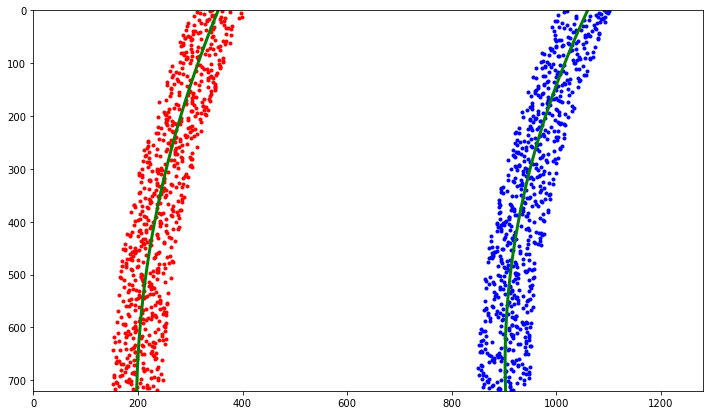

In [491]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.figure(figsize=(12, 7))
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images
plt.show()

In [492]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)


1837.11154064 1413.11010629


In [493]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


603.024634863 m 463.216843906 m
